In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

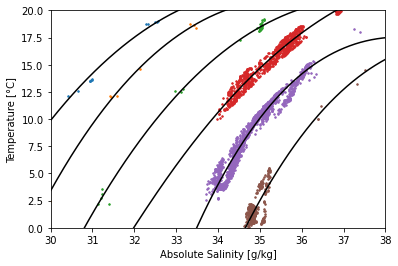

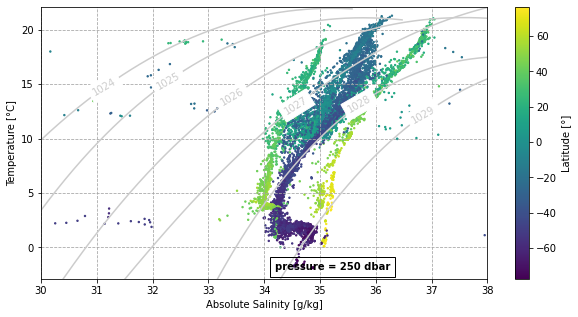

In [1]:
import numpy as np
import gsw.conversions
import numpy.matlib
import matplotlib.pyplot as plt
from netCDF4 import *
import paramTSz as func
import math

ds = Dataset('EN.4.2.1.f.profiles.g10.201901.nc')
    
# temperature (in degC)
T = ds.variables['TEMP'][:]

# practical salinity
PSAL = ds.variables['PSAL_CORRECTED'][:]

# depth
depth = ds.variables['DEPH_CORRECTED'][:]
    
lat = ds.variables['LATITUDE'][:]
long = ds.variables['LONGITUDE'][:]

def diagramTS(T, SP, depth, long, lat, p_layer):
    # Pressure from depth 
    p = gsw.p_from_z(-depth, np.matlib.repmat(lat,len(T[1,:]),1).T) # [dbar]
    
    # Absolute Salinity from Practical Salinity
    SA = gsw.SA_from_SP(SP, p, np.matlib.repmat(long,len(T[1,:]),1).T, np.matlib.repmat(lat,len(T[1,:]),1).T) # [g/kg]
    
    # in-situ density
    rho = gsw.rho(SA, T, p) # [kg/m^3]
    
    #p_find = np.where(p == p_layer)
    p_find = np.where((p > p_layer-1) & (p < p_layer+1))
    
    SA = SA[p_find]
    T = T[p_find]
    rho = rho[p_find]
    
    fRaster_list = []
    xRaster_list = []
    iso_list = []
    plt.figure()
    for iso in range(1024, 1030):
        iso_find = np.where((rho < iso + 0.2) & (rho >= iso - 0.2))

        # approximation
        dkappa = 8
        kappa = np.arange(math.floor(np.min(SA[iso_find])), math.ceil(np.max(SA[iso_find])), dkappa)
        S_sort = np.sort(SA[iso_find])                     # sort SA values
        T_sort = T[iso_find][np.argsort(SA[iso_find])]     # sort T values in corresponding order
        A = func.getA(kappa, dkappa, S_sort)
        xS,lS,v,rp = func.linearGMM(A, T_sort)

        #Evaluation of the function on an equidistant grid
        xRaster = np.arange(np.min(S_sort)-3, np.max(S_sort)+3, (np.max(S_sort)-np.min(S_sort))/10000) # vector with equidistant values
        Ax = func.getA(kappa, dkappa, xRaster)
        fRaster = Ax.dot(xS)
        fRaster_list.append(fRaster)
        xRaster_list.append(xRaster)
        iso_list.append(iso)

        plt.plot(SA[iso_find], T[iso_find], '.', markersize=3, label=str(iso))
        plt.plot(xRaster, fRaster, 'k')
        #plt.text(np.max(SA[iso_find]), np.max(T[iso_find]), str(iso))
        plt.xlim([30, 38])
        plt.ylim([0, 20])
    plt.xlabel("Absolute Salinity [g/kg]")
    plt.ylabel("Temperature [°C]")    
    plt.show()
    
    ax = plt.figure(figsize=(10,5))
    marker_size=2
    plt.xlim([30, 38])
    plt.ylim([np.min(T)-1, np.sort(T)[-10]+1])
    plt.scatter(SA, T, marker_size, c=lat[p_find[0]])
    for i in range(len(xRaster_list)):
        plt.plot(xRaster_list[i], fRaster_list[i], c='0.8', label=str(iso_list[i]))
    func.labelLines(plt.gca().get_lines(),zorder=2.5)
    plt.xlabel("Absolute Salinity [g/kg]")
    plt.ylabel("Temperature [°C]")
    plt.grid(b=True, which='both', color='0.65', linestyle='--')
    cbar= plt.colorbar()
    cbar.set_label("Latitude [°]")
    ax.text(0.45, 0.15, 'pressure = '+str(p_layer)+' dbar', weight='bold', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', pad=5))
    plt.show()

    return

diagramTS(T, PSAL, depth, long, lat, 250)

/home/najona/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


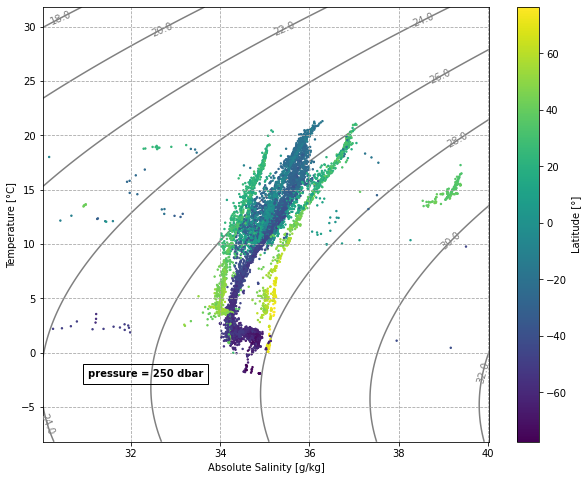

In [2]:
def diagramTS2(T, SP, depth, long, lat, p_layer):
    # Pressure from depth 
    p = gsw.p_from_z(-depth, np.matlib.repmat(lat,len(T[1,:]),1).T) # [dbar]
    
    # Absolute Salinity from Practical Salinity
    SA = gsw.SA_from_SP(SP, p, np.matlib.repmat(long,len(T[1,:]),1).T, np.matlib.repmat(lat,len(T[1,:]),1).T) # [g/kg]
    
    p_find = np.where((p > p_layer-1) & (p < p_layer+1))
    
    medS = np.median(SA[p_find])
    medT = np.median(T[p_find])
    
    tempL=np.linspace(medT-20, medT+20, 200)
    salL=np.linspace(medS-5, medS+5, 200)
    
    Tg, Sg = np.meshgrid(tempL,salL)
    sigma_theta = gsw.sigma0(Sg, Tg)

    cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),500)
    marker_size=2
    fig,ax=plt.subplots(figsize=(10,8))
    plt.xlim([medS-5, medS+5])
    plt.ylim([medT-20, medT+20])
    cs = ax.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
    cl=plt.clabel(cs,fontsize=10,inline=False,fmt='%.1f')
    plt.scatter(SA[p_find], T[p_find], marker_size, c=lat[p_find[0]])
    plt.xlabel("Absolute Salinity [g/kg]")
    plt.ylabel("Temperature [°C]")
    plt.grid(b=True, which='both', color='0.65', linestyle='--')
    cbar= plt.colorbar()
    cbar.set_label("Latitude [°]")
    plt.text(medS-4, medT-14, 'pressure = '+str(p_layer)+' dbar', weight='bold', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', pad=5))

    return

diagramTS2(T, PSAL, depth, long, lat, 250)